# **Facial Recognition using TensorFlow and Keras**





In [ ]:
#import necessary packages to build a tensorflow model 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import tensorflow as tf
import os

from os import listdir 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import google drive and specify path to dataset 
from google.colab import drive
drive.mount("drive") 
print("drive mounted")
path = 'drive/My Drive/CIS 579/Project/dataset/images'
#print(path)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
drive mounted


## **Specify Dataset Location for Training and Validaiton Directories** 




In [ ]:
#Specify training and Validaiton path    

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

#Identify Paths for both classes separately 
train_costanza_dir = os.path.join(train_dir, 'costanza')  
train_kramer_dir = os.path.join(train_dir, 'kramer')  

validation_costanza_dir = os.path.join(validation_dir, 'costanza') 
validation_kramer_dir = os.path.join(validation_dir, 'kramer')  

num_costanza_tr = len(os.listdir(train_costanza_dir))
num_kramer_tr = len(os.listdir(train_kramer_dir))

num_costanza_val = len(os.listdir(validation_costanza_dir))
num_kramer_val = len(os.listdir(validation_kramer_dir))

total_train = num_costanza_tr + num_kramer_tr
total_val = num_costanza_val + num_kramer_val

## **Display Sample Images** 

Text(0.5, 1.0, 'Sample Training Image from Class B')

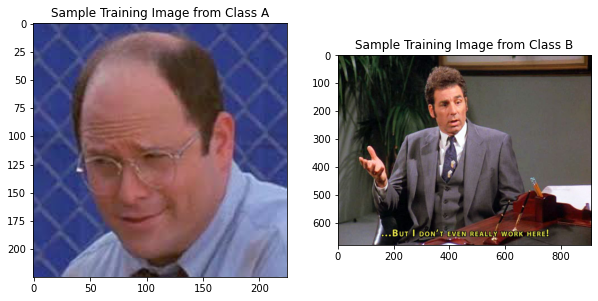

In [ ]:
train_class_a = mpimg.imread('drive/My Drive/CIS 579/Project/dataset/images/train/costanza/costanza11.jpeg')
train_class_b = mpimg.imread('drive/My Drive/CIS 579/Project/dataset/images/train/kramer/kramer11.jpg')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(train_class_a)
plt.title('Sample Training Image from Class A')
plt.subplot(1,2,2)
plt.imshow(train_class_b)
plt.title('Sample Training Image from Class B')



Text(0.5, 1.0, 'Sample Validation Image from Class B')

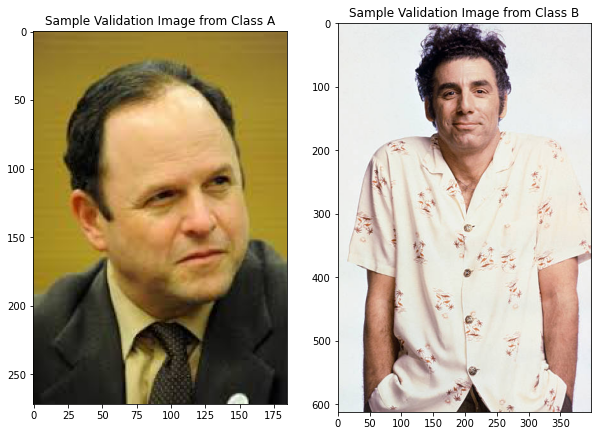

In [ ]:
validation_class_a = mpimg.imread('drive/My Drive/CIS 579/Project/dataset/images/validation/costanza/costanza199.jpeg')
validation_class_b = mpimg.imread('drive/My Drive/CIS 579/Project/dataset/images/validation/kramer/kramer122.jpg')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(validation_class_a)
plt.title('Sample Validation Image from Class A')
plt.subplot(1,2,2)
plt.imshow(validation_class_b)
plt.title('Sample Validation Image from Class B')

## **Prepare Dataset**

* In this section, dataset is prepare data such that it can be used to feed into out tensorflow model. Rescaling the the images is an important pre-processing step sicne RGB image values range from 0 to 255, this is adds substantial load on the learnign rate. The rescale process will normalize the values from 0 to 1 as opposed 0 to 255. 

In [ ]:

train_image_generator = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255) 

* At first, we define, batch size, this is the overall size of the group of data which will be passed on to the neural network. Since,  Colab GPU is fairly powerful for this task, we will use batch size of 64. 

* Next, We define epochs for our neural netowrk. Epochs basiacally mean how many times our entire dataset will be passed through the neural network. This is tunable parameter. We do not want too little epochs, or too many epochs as that would yield either insufficient training, or when there is too many epochs, model will utilize processing power more than necessary, and would yield diminishing returns.  

* Lastly, for data preparation, flow_from_directory class is used to provide chunks of data that can be used as an input for neural network. Since, our image data is sorted, i.e., Person A images are in Person A folder, and not mixed up. This will also resize image to 150 by 150 pixels. We specified the class mode as binary since only two classes of facial recognition will be computed. 



In [ ]:
batch_size = 64
epochs = 30
image_height = 150
image_width = 150

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,
                                                           target_size=(image_height, image_width), class_mode='binary')


val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size, directory=validation_dir, 
                                                              target_size=(image_height, image_width), class_mode='binary')




Found 250 images belonging to 2 classes.
Found 160 images belonging to 2 classes.





# **Setup a Training Model**

In this section, we define our Convolutional Neural Network. Once the model has been trained with our dataset, it should be able to recognize two classes with very high accuracy.

* In this model, we define the model as sequential as it allows us to create models layer by layer. The other model type is functional, which would not be relevant to this problem as when Functional model is defined, it allows layers to have multiple inputs and outputs and can connect to previous layers as well. 

* Next, we define convolution network;s layer one at a time. The first layer of 32 neurons takes image shape (height, width, and 3 channel (RGB) as an input, which is activated using relu. Afterwards, we utilize maxpooling2d function, which esentially down-samples the input data by taking the the maximum value of 2x2 matrix. The following layers will automatically take inputs from prior neurons. We will also increase the number of neurons seqentially after our first layer is defined. 

* Dropout rate of 50% is defined once all layers have been setup. Dropping or deactivating the neurons at ranom is done so to prevent over-fitting problem. Afterwards, we need to flatten our model into a normal array. Lastly, we can create a final output layer. In our case, since we have two classes to identify, we have selected output of 2 with activation of softmax. 

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_height, image_width, 3)), # RGB
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Dropout(0.5), 
    Flatten(),
    Dense(256, activation='relu'),
    
    Dense(2, activation='softmax') 
    
   ])

### **Compile the model**

Before training the model, there are few last steps such as loss function, optimizier, and metrics. 

* Loss Function messaures how accurate the model is during the tranining. Since our model only has two classes to recognize, sparse_cateogorical_crossentropy losss function has been selected. 

* Optimizer is how the model is updated based on the data observed and its loss function. The default adam optimizer was selected for the training.

* Metrics is used to monitor the training and testing steps. Here we utilize tensorflow's inbuilt accuracy class. 

In [ ]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# **Training the Model**

* Finally, we train our model to iterrate through 30 epocch. This number was selected by observation. It was discovered that 15 epochs gave approximately 80% accuracy, so to further build accuracy the epoch was increased. 

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
3/3 [==============================] - 181s 60s/step - loss: 0.7130 - accuracy: 0.5054 - val_loss: 0.6827 - val_accuracy: 0.6562
Epoch 2/30
3/3 [==============================] - 8s 3s/step - loss: 0.6817 - accuracy: 0.5860 - val_loss: 0.6960 - val_accuracy: 0.6016
Epoch 3/30
3/3 [==============================] - 8s 3s/step - loss: 0.6557 - accuracy: 0.6302 - val_loss: 0.6861 - val_accuracy: 0.6562
Epoch 4/30
3/3 [==============================] - 8s 3s/step - loss: 0.6479 - accuracy: 0.6452 - val_loss: 0.6925 - val_accuracy: 0.6094
Epoch 5/30
3/3 [==============================] - 8s 3s/step - loss: 0.6634 - accuracy: 0.6129 - val_loss: 0.6695 - val_accuracy: 0.6641
Epoch 6/30
3/3 [==============================] - 8s 3s/step - loss: 0.6693 - accuracy: 0.6022 - val_loss: 0.6808 - val_accuracy: 0.6328
Epoch 7/30
3/3 [==============================] - 8s 3s/step - loss: 0.6501 - accuracy: 0.6075 - va

# **Accuracy of the Model**

* As we can observe, our Covolutional Neural Network is highly accurate as it yields 97% accuracy. Even though our dataset was not large enough as the images were downloaded grom Google Images, we have a high accuracy in identifying the two classes. 

* It can be noted from the plot that we have underfitting scenario in our model since trainning loss is less than valication loss. This can be further improved by fine tuining the parameters of the model as well as increasing the images in our dataset. Additionally, further pre-processing such as image augmentation can also be performed to improve the accuracy. 

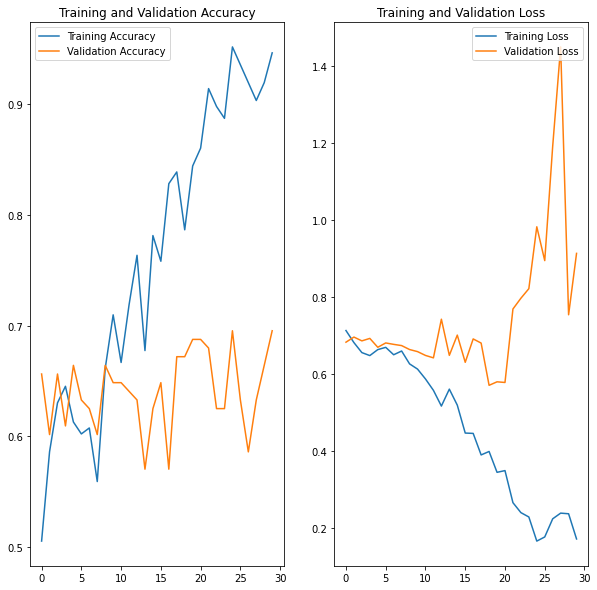

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('drive/My Drive/CIS 579/Project/keras.h5')

# **Prediction**

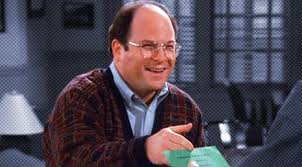

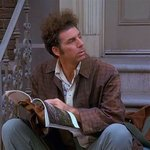

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

## Save the model as .h5 format that Keras supports, and re-compile to use for prediction 
model= tf.keras.models.load_model("drive/My Drive/CIS 579/Project/keras.h5")

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

img = cv2.imread('drive/My Drive/CIS 579/Project/dataset/images/0.jpg')
img2 = cv2.imread('drive/My Drive/CIS 579/Project/dataset/images/1.jpg')
cv2_imshow(img)
cv2_imshow(img2)

img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])

img2 = cv2.resize(img2,(150,150))
img2 = np.reshape(img2,[1,150,150,3])



* Two random images were tested for both classes to test prediction accuracy. Images had to be rezied to the same scale as trainned data so that the model could use it as an input. We we can observe below that the model correctly identified Costanza as a match for class [0], and Kramer as a match for Class [1]. In both instances, model predicted with 100% confidance. 

In [ ]:
predict = model.predict_proba(img)
print(predict)

predict = model.predict_proba(img2)
print(predict)



[[1. 0.]]
[[0. 1.]]
